In [2]:
!pip install category_encoders

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
import category_encoders as ce
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


df = pd.read_csv('/content/df_cafes_.csv')
df.head()

,name,type,cuisine,website,lat,lon,dgis_general_rating,dgis_general_review_count_with_stars,dgis_org_rating,dgis_org_review_count,city,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name,other_attractions_100m,other_attractions_500m,other_attractions_1000m,parks_100m,parks_500m,parks_1000m,nearest_park,nearest_park_name,res_buildings_density_1000m
0,Salden's Taphouse,bar,NaN,1,55.765574,37.638976,4.9,129.0,4.8,252.0,Москва,single,0,0,0,95,408,13,4,54,238,0.173469,0.333767,0.343715,2,16,78,0,3,13,0,5,33,172.821378,33.217640,1,3,7,0,0,0,1426.018645,1727.181932,3,24,78,0,6,24,7,95,389,34.065240,0,4,14,248.184472,"Музей ПАО ""Лукойл""",0,3,12,204.141909,Et Cetera,0,9,19,288.163295,Nadja Brykina Gallery,1,65,220,0,6,27,247.780090,Сквер «Огородная слобода»,132.416913
1,Com,cafe,vietnamese,0,55.768280,37.644618,3.5,12.0,4.5,164.0,Москва,Com,1,3,0,47,293,5,0,0,0,0.722222,0.363599,0.330499,1,11,49,1,2,11,1,10,45,48.888462,286.369046,0,4,6,0,0,1,986.998623,2191.887123,0,12,76,0,7,25,2,82,295,43.845174,0,0,8,561.750365,Музей-квартира А.М. Васнецова,0,1,16,447.794659,Московский театр Олега Табакова,0,1,12,346.831736,Sare art,1,73,179,2,9,32,42.032631,(без названия),113.954939
2,Шоколадница,cafe,coffee_shop,1,55.738811,37.653006,2.4,170.0,3.1,10899.0,Москва,Шоколадница,20,51,2,69,149,0,0,1,2,0.333333,0.162963,0.262394,0,11,23,0,4,10,3,27,56,29.415921,196.757801,0,3,3,0,0,0,1317.203154,2918.277235,0,15,52,0,5,23,0,28,175,105.770517,0,2,9,399.342022,Музей холодной войны (экспозиционный комплекс ...,0,2,9,447.416636,Театр на Таганке,0,1,2,305.446600,Краснохолмская,0,16,50,1,2,8,91.996504,(без названия),56.659160
3,Тануки,restaurant,japanese,1,55.728517,37.679155,4.9,527.0,4.8,24921.0,Москва,Тануки,0,0,0,9,29,0,0,0,0,1.000000,0.220000,0.184444,0,2,18,0,3,5,2,9,38,35.096513,607.640383,0,0,3,0,0,1,941.136113,4915.167829,0,7,23,1,6,17,0,6,34,260.951984,1,1,1,82.206021,Музей Русской Культуры,0,1,2,486.621836,Театр на Мельникова,0,0,0,1459.137150,Здесь на Таганке,2,4,12,0,0,7,509.973891,(без названия),46.791553
4,Вареничная №1,restaurant,russian,1,55.732211,37.665123,4.1,201.0,4.1,3881.0,Москва,Вареничная №1,0,0,0,30,85,7,0,0,0,0.125000,0.196670,0.268253,2,11,34,0,2,7,2,19,54,55.216956,61.699030,1,2,2,0,0,0,1552.368935,3974.418292,0,12,37,0,4,24,2,17,63,85.360818,0,0,5,554.395227,Усыпальница бояр Романовых,0,1,3,449.965013,Московский детский театр марионеток,0,0,1,984.161965,Краснохолмская,0,7,30,0,2,9,191.115200,(без названия),69.709865


In [4]:
# Напишем функцию для создания таргета
def get_target(df, m = 20, alpha = 1, beta = 1):

  rating_col = "dgis_general_rating" # колонка с рейтингом кафе R_i
  reviews_col = "dgis_general_review_count_with_stars" # колонка с числом отзывов v_i

  # WR
  R = df[rating_col]
  v = df[reviews_col].fillna(0)

  C = R.mean() # средний рейтинг по всем кафе

  df["WR"] = (v / (v + m)) * R + (m / (v + m)) * C

  # Vol_i = log(1 + v_i)
  df["Vol"] = np.log1p(v) # log(1 + v_i)

  # cтандартизация WR и Vol
  WR_mean = df["WR"].mean()
  WR_std  = df["WR"].std()

  Vol_mean = df["Vol"].mean()
  Vol_std  = df["Vol"].std()

  df["zWR"]  = (df["WR"]  - WR_mean)  / WR_std
  df["zVol"] = (df["Vol"] - Vol_mean) / Vol_std

  # итоговый таргет
  df["cafe_success_index"] = alpha * df["zWR"] + beta * df["zVol"]

  return df

In [5]:
df_cafes = get_target(df)

# уберем лишние колонки
df_cafes.drop(columns = ["zWR", "WR", "zVol", "Vol", "dgis_general_rating", "dgis_org_rating",
                         "dgis_general_review_count_with_stars", "city"], inplace = True)
df_cafes['cafe_success_index'].sample(5)

,cafe_success_index
7754,0.653539
8479,1.166926
691,-2.952849
675,3.009900
2777,2.467961


<Axes: >

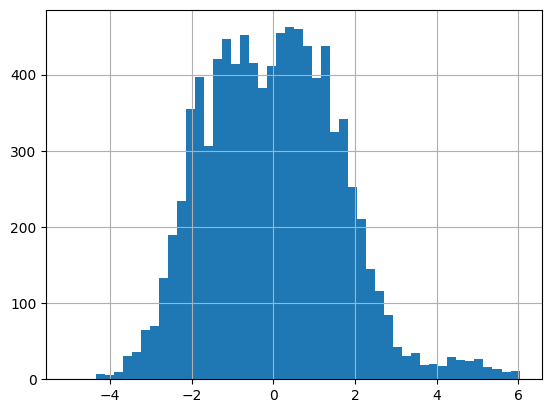

In [6]:
df_cafes['cafe_success_index'].hist(bins = 50)

Распределение зависимой переменной близко к нормальному -> предобработкой компонент нашей завсимой переменной мы убрали излишнее влияние экстремальных объектов на нашу зависимую переменную и вклад каждого наблюдения в MSE теперь будет более равномерным -> для такой зависимой переменной можно применять линейные модели

Теперь хорошо бы посмотреть на зависимости в данных:

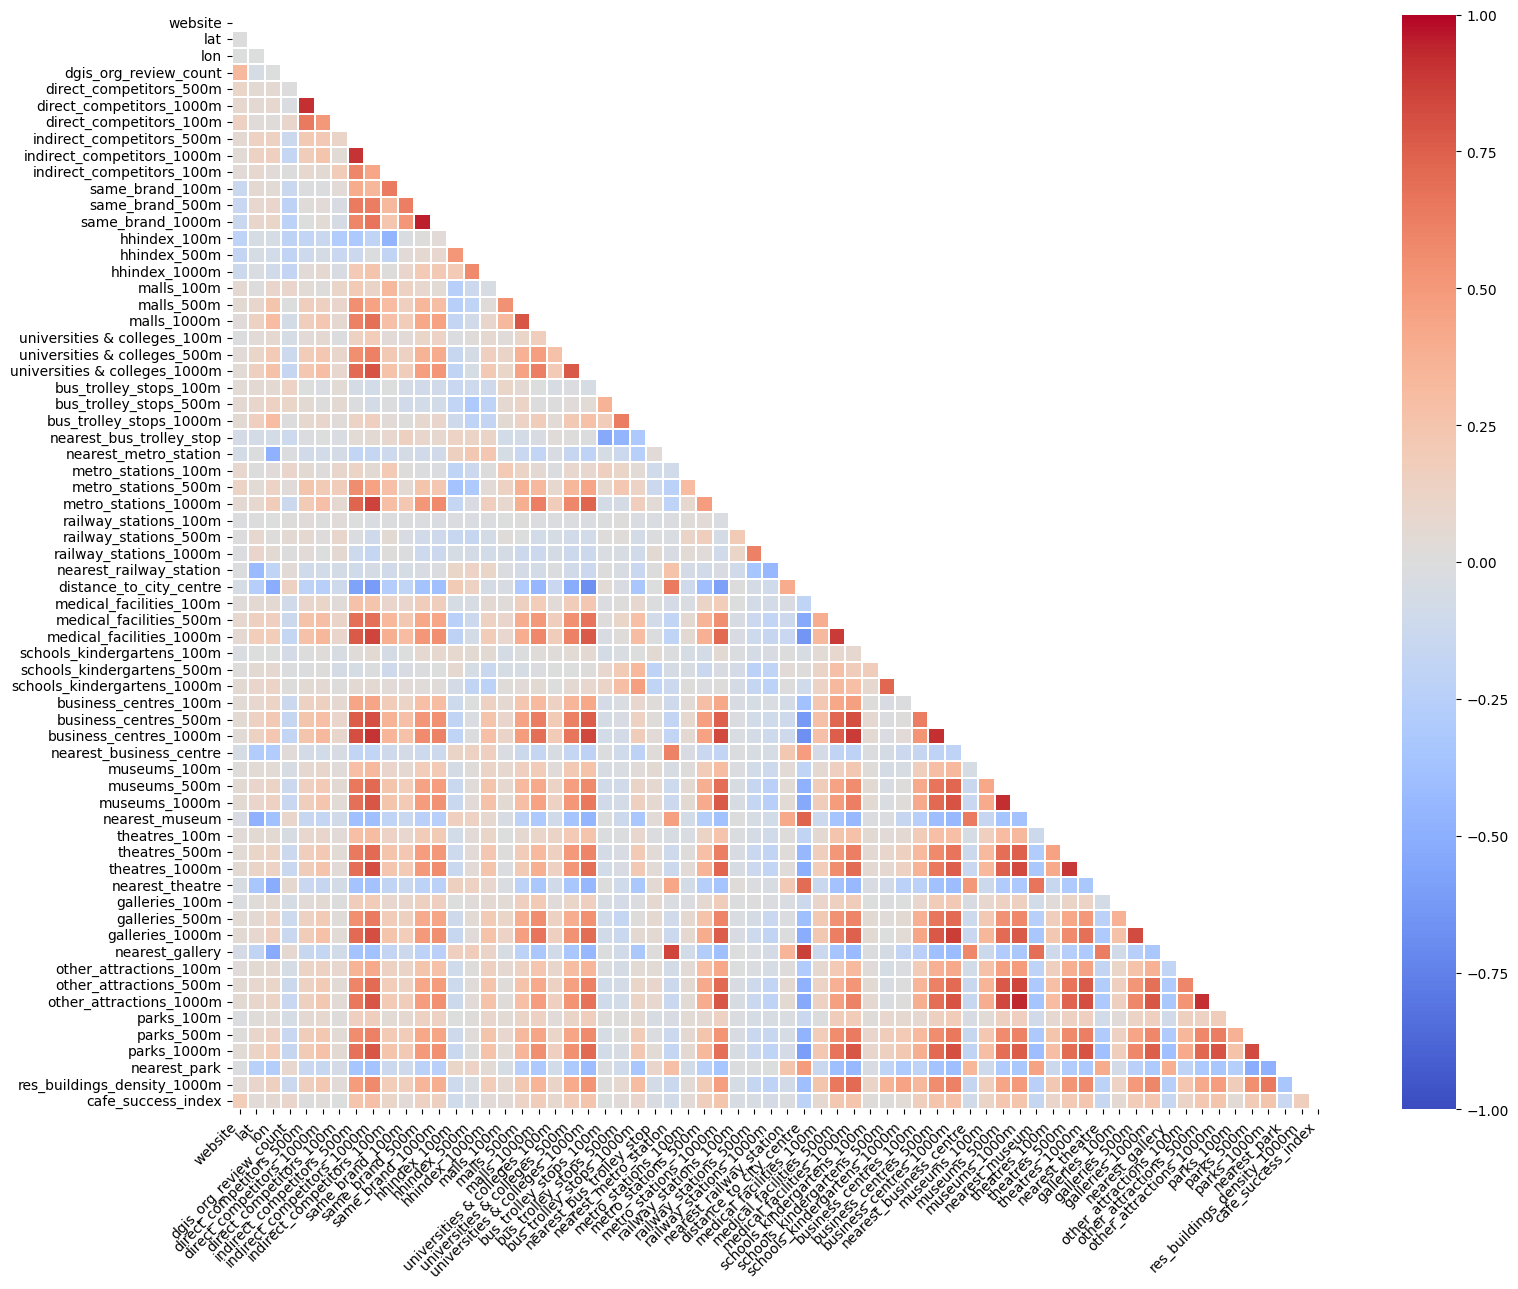

In [7]:
# построим корреляцию Пирсона
num_cols = df_cafes.select_dtypes(include=[np.number])
pearson_corr = num_cols.corr()

plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))

sns.heatmap(pearson_corr, mask=mask, cmap="coolwarm", vmin=-1, vmax=1, center=0, annot=False, square=True, linewidths=0.3)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Как видно из тепловой карты, cafe_success_index практически не коррелирует с остальными числовыми признаками. Надо посмотреть теперь корреляцию η категориальных признаков с зависимой переменной

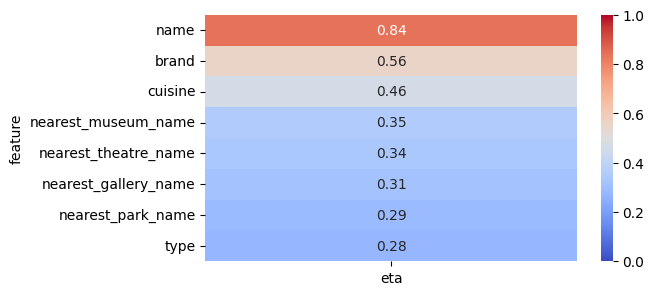

In [8]:
# корреляция категориальная / числовая переменная
def eta(cat, y):
    s = pd.DataFrame({"cat": cat, "y": y}).dropna()
    if s["cat"].nunique() <= 1:
        return np.nan
    g = s.groupby("cat")["y"]
    means, counts = g.mean(), g.size()
    overall = s["y"].mean()
    ss_between = ((means - overall) ** 2 * counts).sum()
    ss_total = ((s["y"] - overall) ** 2).sum()
    return np.sqrt(ss_between / ss_total) if ss_total else np.nan

target = "cafe_success_index"

# только категориальные признаки
cat_cols = df_cafes.select_dtypes(include=["object", "category"]).columns

# η для каждой категориальной фичи
etas = pd.Series(
    {col: eta(df_cafes[col], df_cafes[target]) for col in cat_cols},
    name="eta"
).sort_values(ascending=False)

# heatmap
plt.figure(figsize=(6, max(3, 0.4 * len(etas))))
sns.heatmap(etas.to_frame(), annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.ylabel("feature")
plt.yticks(rotation=0)
plt.show()



Видно, что у cafe_success_index высокий положительный коэффициент эта-корреляции η с признаками name и brand. Это может говорить о том, что получившийся индекс успешности зависит скорее от параметров заведения, чем от его местоположения. На успешность заведения в данной постановке задачи будут в большей степени влиять имя ресторана (репутация) или имя сети, к которой он принадлежит (репутация сети).

In [9]:
# разделяем треин тест
X = df_cafes.drop(columns = ['cafe_success_index'])
y = df_cafes['cafe_success_index']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

Преобразуем зависимую переменную к шкале [0.00;5.00]

In [10]:
# cчитаем min/max только по train
y_min = y_train.min()
y_max = y_train.max()

# преобразуем train и test в [0, 5]
def scale_to_0_5(y, y_min, y_max):
    return 5 * (y - y_min) / (y_max - y_min)

y_train = scale_to_0_5(y_train, y_min, y_max)
y_test  = scale_to_0_5(y_test,  y_min, y_max)


<Axes: >

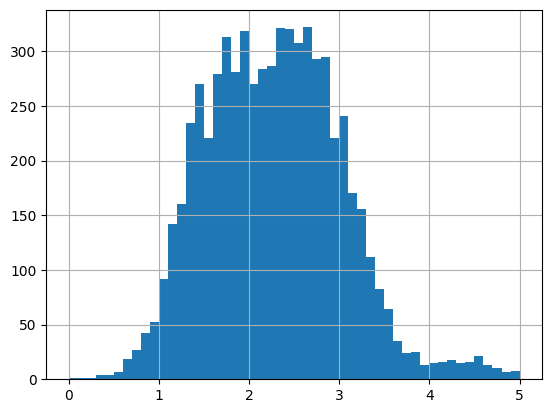

In [11]:
y_train.hist(bins = 50)

Напишем функции для кодирования категориальных признаков по частотам и стандартным one hot encoding:

In [12]:
# one - hot - encoding
def ohe_encoding(df_train, df_test, stop_columns=None):
    if stop_columns is None:
        stop_columns = []

    cat_features_ohe = [col for col in df_train.columns if (df_train[col].dtype == "object" or str(df_train[col].dtype) == "category")
        and col not in stop_columns]

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
    ohe.fit(df_train[cat_features_ohe])

    train_ohe = ohe.transform(df_train[cat_features_ohe])
    test_ohe = ohe.transform(df_test[cat_features_ohe])

    train_ohe_df = pd.DataFrame(
        train_ohe,
        columns=ohe.get_feature_names_out(cat_features_ohe),
        index=df_train.index,
    )

    test_ohe_df = pd.DataFrame(
        test_ohe,
        columns=ohe.get_feature_names_out(cat_features_ohe),
        index=df_test.index,
    )

    df_train = pd.concat([df_train.drop(columns=cat_features_ohe), train_ohe_df], axis=1)
    df_test = pd.concat([df_test.drop(columns=cat_features_ohe), test_ohe_df], axis=1)

    return df_train, df_test

# frequency encoding
def freq_encoding(df_train, df_test, stop_columns=None):

    if stop_columns is None:
        stop_columns = []

    cat_features_freq = [col for col in df_train.columns if (df_train[col].dtype == "object" or str(df_train[col].dtype) == "category")
        and col not in stop_columns]

    freq_encoder = ce.CountEncoder(cols=cat_features_freq, normalize=True)
    freq_encoder.fit(df_train[cat_features_freq])

    train_cols_encoded = freq_encoder.transform(df_train[cat_features_freq])
    test_cols_encoded = freq_encoder.transform(df_test[cat_features_freq])

    for col in cat_features_freq:
        df_train[col] = train_cols_encoded[col]
        df_test[col] = test_cols_encoded[col]

    return df_train, df_test

In [13]:
# закодируем категориальные признаки
stop_cols = ['name', 'brand', 'nearest_museum_name',
             'nearest_theatre_name', 'nearest_gallery_name',
             'nearest_park_name']


X_train, X_test = ohe_encoding(X_train, X_test, stop_columns = stop_cols)

stop_cols = [col for col in X_train.columns if col not in stop_cols]
X_train, X_test = freq_encoding(X_train, X_test, stop_columns = stop_cols)
X_train.head()

,name,website,lat,lon,dgis_org_review_count,brand,direct_competitors_500m,direct_competitors_1000m,direct_competitors_100m,indirect_competitors_500m,indirect_competitors_1000m,indirect_competitors_100m,same_brand_100m,same_brand_500m,same_brand_1000m,hhindex_100m,hhindex_500m,hhindex_1000m,malls_100m,malls_500m,malls_1000m,universities & colleges_100m,universities & colleges_500m,universities & colleges_1000m,bus_trolley_stops_100m,bus_trolley_stops_500m,bus_trolley_stops_1000m,nearest_bus_trolley_stop,nearest_metro_station,metro_stations_100m,metro_stations_500m,metro_stations_1000m,railway_stations_100m,railway_stations_500m,railway_stations_1000m,nearest_railway_station,distance_to_city_centre,medical_facilities_100m,medical_facilities_500m,medical_facilities_1000m,schools_kindergartens_100m,schools_kindergartens_500m,schools_kindergartens_1000m,business_centres_100m,business_centres_500m,business_centres_1000m,nearest_business_centre,museums_100m,museums_500m,museums_1000m,nearest_museum,nearest_museum_name,theatres_100m,theatres_500m,theatres_1000m,nearest_theatre,nearest_theatre_name,galleries_100m,galleries_500m,galleries_1000m,nearest_gallery,nearest_gallery_name,other_attractions_100m,other_attractions_500m,other_attractions_1000m,parks_100m,parks_500m,parks_1000m,nearest_park,nearest_park_name,res_buildings_density_1000m,type_cafe,type_coffee,type_confectionery,type_fast_food,type_food_court,type_ice_cream,type_marketplace,type_pub,type_restaurant,type_tea,cuisine_african;ethiopian,cuisine_american,cuisine_american;burger;coffee_shop;sandwich,cuisine_american;chinese;fish_and_chips;chicken;burger;friture;hot_dog;italian;coffee_shop;cake;russian;sandwich;sausage,cuisine_american;pizza,cuisine_arab,cuisine_argentinian,cuisine_armenian,cuisine_asian,cuisine_asian;burger,cuisine_asian;japanese;sushi,cuisine_asian;korean,cuisine_asian;noodle,cuisine_azerbaijan,cuisine_azerbaijani,cuisine_balkan;kebab;oriental,cuisine_barbecue,cuisine_barbecue;fish;grill;steak_house,cuisine_barbecue;grill;kebab,cuisine_bavarian,cuisine_bavarian;german,cuisine_beef,cuisine_belarusian,cuisine_belgian,cuisine_brazilian,cuisine_breakfast,cuisine_breakfast;burger;coffee_shop;pasta,cuisine_breakfast;cake;coffee_shop,cuisine_breakfast;cake;coffee_shop;international;italian;italian_pizza,cuisine_breakfast;coffee_shop,cuisine_bubble_tea,cuisine_bulgarian,cuisine_burger,cuisine_burger;breakfast;coffee_shop,cuisine_burger;coffee_shop;italian;pizza;russian,cuisine_burger;deli;breakfast;grill;coffee_shop;tea;friture;german;fish_and_chips;sausage;american;bavarian;barbecue,cuisine_burger;friture;chicken;coffee_shop;pasta;russian;fish_and_chips;sandwich,cuisine_burger;german,cuisine_burger;hot_dog;shawarma;soup;salad,cuisine_burger;italian;japanese;pizza;seafood;sushi,cuisine_burger;seafood;pizza;pasta,cuisine_burger;steak_house;beer,cuisine_cake,cuisine_cake;coffee_shop,cuisine_cake;coffee_shop;sandwich,cuisine_caucasian,cuisine_caucasian;russian,cuisine_chicken,cuisine_chicken;burger;coffee_shop;pasta,cuisine_chicken;grill;kebab,cuisine_chinese,cuisine_chinese;asian,cuisine_coffee;sandwich;bakery;tea,cuisine_coffee_shop,cuisine_coffee_shop;burger,cuisine_coffee_shop;cake,cuisine_coffee_shop;cake;breakfast,cuisine_coffee_shop;cake;sandwich;burger,cuisine_coffee_shop;dessert;international,cuisine_coffee_shop;donut;tea,cuisine_coffee_shop;hot_dog;ice_cream,cuisine_coffee_shop;ice_cream;cake,cuisine_coffee_shop;international,cuisine_coffee_shop;international;eggs,cuisine_coffee_shop;international;mediterranean,cuisine_coffee_shop;italian,cuisine_coffee_shop;kebab;oriental;russian,cuisine_coffee_shop;pastry;tea;breakfast;sandwich;dessert,cuisine_coffee_shop;pie,cuisine_coffee_shop;sandwich,cuisine_coffee_shop;sandwich;chicken,cuisine_coffee_shop;tea,cuisine_crepe,cuisine_crepe;russian,cuisine_czech,cuisine_deli,cuisine_deli;seafood;burger;hotdog,cuisine_dessert,cuisine_doner,cuisine_donut,cuisine_donut;coffee_shop,cuisine_donut;pizza;german;tea;cake;coffee_

In [13]:
X_train.shape

(6452, 313)

Попробуем L1 линейную регрессию

In [14]:
# для дальнейших сравнений результатов моделей создадим словарь
benchmark = {}

In [15]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso())
])

In [16]:
'''param_grid = {
    "lasso__alpha": [0.1, 1, 100, 1000, 3000, 5000],
    "lasso__max_iter": [500, 1000, 3000],
    "lasso__selection": ["cyclic", "random"],
    "lasso__fit_intercept": [True, False],
    "lasso__positive": [True, False],
    "lasso__precompute": [True, False, "auto"],
    "lasso__warm_start": [True, False],
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
best_model = gs.best_estimator_
print(gs.best_params_)'''

'param_grid = {\n    "lasso__alpha": [0.1, 1, 100, 1000, 3000, 5000],\n    "lasso__max_iter": [500, 1000, 3000],\n    "lasso__selection": ["cyclic", "random"],\n    "lasso__fit_intercept": [True, False],\n    "lasso__positive": [True, False],\n    "lasso__precompute": [True, False, "auto"],\n    "lasso__warm_start": [True, False],\n}\n\ngs = GridSearchCV(\n    estimator=pipe,\n    param_grid=param_grid,\n    cv=10,\n    scoring="neg_mean_squared_error",\n    n_jobs=-1,\n    verbose=1\n)\n\ngs.fit(X_train, y_train)\nbest_model = gs.best_estimator_\nprint(gs.best_params_)'

In [130]:
# оцениваем качество
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# R^2
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# MSE
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)

# RMSE = sqrt(MSE)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mse_train)

# MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
# добавляем в бенчмарк для сравнения моделей
benchmark['L1_регрессия'] = [r2_test, mse_test, rmse_test, mae_test]

print("TEST:")
print("R^2 (test):", r2_test)
print("MSE (test):", mse_test)
print("RMSE(test):", rmse_test)
print("MAE (test):", mae_test)

print("\nTRAIN:")
print("R^2 (train):", r2_train)
print("MSE (train):", mse_train)
print("RMSE(train):", rmse_train)
print("MAE (train):", mae_train)

TEST:
R^2 (test): 0.10689772222793592
MSE (test): 0.4816426861121321
RMSE(test): 0.694004817066951
MAE (test): 0.5585834588690156

TRAIN:
R^2 (train): 0.09727370690688064
MSE (train): 0.5081809974233823
RMSE(train): 0.7128681486946813
MAE (train): 0.5718852314605088


Попробуем L2 линейную регрессию

In [18]:
pipe_l2 = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

param_grid_l2 = {

    "ridge__alpha": [0.1, 1, 100, 1000, 3000],

    "ridge__max_iter": [None, 1000, 3000],

    "ridge__fit_intercept": [True, False],

    "ridge__positive": [False, True],
}

gs_l2 = GridSearchCV(
    estimator=pipe_l2,
    param_grid=param_grid_l2,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

gs_l2.fit(X_train, y_train)

best_model_l2 = gs_l2.best_estimator_
print(gs_l2.best_params_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
{'ridge__alpha': 1000, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__positive': False}


In [19]:
# оцениваем качество
y_pred_test = best_model_l2.predict(X_test)
y_pred_train = best_model_l2.predict(X_train)

# R^2
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# MSE
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)

# RMSE = sqrt(MSE)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mse_train)

# MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
# добавляем в бенчмарк для сравнения моделей
benchmark['L2_регрессия'] = [r2_test, mse_test, rmse_test, mae_test]

print("TEST:")
print("R^2 (test):", r2_test)
print("MSE (test):", mse_test)
print("RMSE(test):", rmse_test)
print("MAE (test):", mae_test)

print("\nTRAIN:")
print("R^2 (train):", r2_train)
print("MSE (train):", mse_train)
print("RMSE(train):", rmse_train)
print("MAE (train):", mae_train)

TEST:
R^2 (test): 0.2256459586202011
MSE (test): 0.4176027424567134
RMSE(test): 0.6462218987752686
MAE (test): 0.5096435148835814

TRAIN:
R^2 (train): 0.2601907946598516
MSE (train): 0.41646840548375963
RMSE(train): 0.6453436336431619
MAE (train): 0.5056013865878506


Попробуем ElasticNet

In [25]:
pipe_elastic = Pipeline([
    ("scaler", StandardScaler()),
    ("elastic", ElasticNet())
])

param_grid_elastic = {

    # общий коэффициент регуляризации
    "elastic__alpha": [0.1, 1, 100, 1000, 3000, 5000],

    # доля L1-регуляризации (0 = чистый L2, 1 = чистый L1)
    "elastic__l1_ratio": [0.1, 0.5, 0.7, 1.0],

    "elastic__max_iter": [500, 1000, 5000, 10000],

    # схема обхода признаков
    "elastic__selection": ["cyclic", "random"],

    # учить ли свободный член
    "elastic__fit_intercept": [True, False],

    "elastic__positive": [True, False]

}


gs_elastic = GridSearchCV(
    estimator=pipe_elastic,
    param_grid=param_grid_elastic,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

gs_elastic.fit(X_train, y_train)

best_model_elastic = gs_elastic.best_estimator_
print("Best params:", gs_elastic.best_params_)

Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Best params: {'elastic__alpha': 0.1, 'elastic__fit_intercept': True, 'elastic__l1_ratio': 0.1, 'elastic__max_iter': 10000, 'elastic__positive': False, 'elastic__selection': 'random'}


In [26]:
# оцениваем качество
y_pred_test = best_model_elastic.predict(X_test)
y_pred_train = best_model_elastic.predict(X_train)

# R^2
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# MSE
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)

# RMSE = sqrt(MSE)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mse_train)

# MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
# добавляем в бенчмарк для сравнения моделей
benchmark['Elastic_регрессия'] = [r2_test, mse_test, rmse_test, mae_test]

print("TEST:")
print("R^2 (test):", r2_test)
print("MSE (test):", mse_test)
print("RMSE(test):", rmse_test)
print("MAE (test):", mae_test)

print("\nTRAIN:")
print("R^2 (train):", r2_train)
print("MSE (train):", mse_train)
print("RMSE(train):", rmse_train)
print("MAE (train):", mae_train)

TEST:
R^2 (test): 0.2257017159183673
MSE (test): 0.41757267300607215
RMSE(test): 0.6461986327794822
MAE (test): 0.5117492156775962

TRAIN:
R^2 (train): 0.23371420451232316
MSE (train): 0.4313731447081362
RMSE(train): 0.6567900309140937
MAE (train): 0.5219253488087344


Попробуем SVR:

In [30]:
svr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(
        kernel="rbf",
        C=0.08,
        epsilon=0.2,
        gamma="scale"
    ))
])

svr_model.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', SVR(C=0.08, epsilon=0.2))])

In [31]:
# оцениваем качество
y_pred_test = svr_model.predict(X_test)
y_pred_train = svr_model.predict(X_train)

# R^2
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# MSE
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)

# RMSE = sqrt(MSE)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mse_train)

# MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
# добавляем в бенчмарк для сравнения моделей
benchmark['SVR'] = [r2_test, mse_test, rmse_test, mae_test]

print("TEST:")
print("R^2 (test):", r2_test)
print("MSE (test):", mse_test)
print("RMSE(test):", rmse_test)
print("MAE (test):", mae_test)

print("\nTRAIN:")
print("R^2 (train):", r2_train)
print("MSE (train):", mse_train)
print("RMSE(train):", rmse_train)
print("MAE (train):", mae_train)

TEST:
R^2 (test): 0.191712314272109
MSE (test): 0.43590287674162465
RMSE(test): 0.6602294122058064
MAE (test): 0.5178573506425856

TRAIN:
R^2 (train): 0.2206620516104446
MSE (train): 0.4387207273928857
RMSE(train): 0.6623599681388405
MAE (train): 0.5176802910141384


Попробуем KNN

In [41]:

pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])


param_grid_knn = {

    "knn__n_neighbors": [3, 5, 10, 20, 30],

    "knn__weights": ["uniform", "distance"],

    "knn__p": [1, 2],

    "knn__metric": ["minkowski"],
}

gs_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)


gs_knn.fit(X_train, y_train)

best_knn = gs_knn.best_estimator_
print("Best params (KNN):", gs_knn.best_params_)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params (KNN): {'knn__metric': 'minkowski', 'knn__n_neighbors': 30, 'knn__p': 2, 'knn__weights': 'distance'}


In [42]:
# оцениваем качество
y_pred_test = best_knn.predict(X_test)
y_pred_train = best_knn.predict(X_train)

# R^2
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# MSE
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)

# RMSE = sqrt(MSE)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mse_train)

# MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
# добавляем в бенчмарк для сравнения моделей
benchmark['KNN'] = [r2_test, mse_test, rmse_test, mae_test]

print("TEST:")
print("R^2 (test):", r2_test)
print("MSE (test):", mse_test)
print("RMSE(test):", rmse_test)
print("MAE (test):", mae_test)

print("\nTRAIN:")
print("R^2 (train):", r2_train)
print("MSE (train):", mse_train)
print("RMSE(train):", rmse_train)
print("MAE (train):", mae_train)

TEST:
R^2 (test): 0.2045459002993143
MSE (test): 0.42898182973454063
RMSE(test): 0.6549670447698424
MAE (test): 0.5189595659422117

TRAIN:
R^2 (train): 0.9999999999964818
MSE (train): 1.9805000807170074e-12
RMSE(train): 1.4073024126736255e-06
MAE (train): 8.084816360219472e-07


In [43]:
benchmark

{'L1_регрессия': [0.10689772222793592,
  0.4816426861121321,
  0.694004817066951,
  0.5585834588690156],
 'L2_регрессия': [0.2256459586202011,
  0.4176027424567134,
  0.6462218987752686,
  0.5096435148835814],
 'Elastic_регрессия': [0.2257017159183673,
  0.41757267300607215,
  0.6461986327794822,
  0.5117492156775962],
 'SVR': [0.191712314272109,
  0.43590287674162465,
  np.float64(0.6602294122058064),
  0.5178573506425856],
 'KNN': [0.2045459002993143,
  0.42898182973454063,
  np.float64(0.6549670447698424),
  0.5189595659422117]}

In [46]:
first_vals = {k: v[0] for k, v in benchmark.items()}

benchmark_r_2 = pd.DataFrame([first_vals])
benchmark_r_2

,L1_регрессия,L2_регрессия,Elastic_регрессия,SVR,KNN
0,0.106898,0.225646,0.225702,0.191712,0.204546


Проведём свой гридсёрч по кастомным параметрам таргета m, alpha и beta на лучшей модели ElasticNet

In [51]:
# копируем датасет
df_base = df.copy()

train_idx, test_idx = train_test_split(
    df_base.index,
    test_size=0.2,
    random_state=42
)


# функция для оценки модели по параметрам alpha, beta, m в зависимой переменной
def evaluate_config(m_value, alpha_value, beta_value):
    df_m = get_target(df_base.copy(), m=m_value, alpha=alpha_value, beta=beta_value)

    # убираем лишние колонки
    drop_cols = [
        "zWR", "WR", "zVol", "Vol",
        "dgis_general_rating", "dgis_org_rating",
        "dgis_general_review_count_with_stars", "city"
    ]
    df_m = df_m.drop(columns=[c for c in drop_cols if c in df_m.columns])

    # X и y
    y = df_m["cafe_success_index"]
    X = df_m.drop(columns=["cafe_success_index"])

    X_train_raw = X.loc[train_idx].copy()
    X_test_raw  = X.loc[test_idx].copy()
    y_train = y.loc[train_idx].copy()
    y_test  = y.loc[test_idx].copy()

    # масштабируем таргет [0; 5] (min/max по train)
    y_min = y_train.min()
    y_max = y_train.max()

    def scale_to_0_5(y_vals, y_min, y_max):
        return 5 * (y_vals - y_min) / (y_max - y_min)

    y_train = scale_to_0_5(y_train, y_min, y_max)
    y_test  = scale_to_0_5(y_test,  y_min, y_max)

    stop_cols_ohe = [
        "name", "brand", "nearest_museum_name",
        "nearest_theatre_name", "nearest_gallery_name",
        "nearest_park_name"
    ]

    # сначала OHE для всех категориальных, кроме stop_cols_ohe
    X_train_enc, X_test_enc = ohe_encoding(
        X_train_raw, X_test_raw,
        stop_columns=stop_cols_ohe
    )

    # затем frequency encoding только для stop_cols_ohe
    stop_cols_freq = [
        col for col in X_train_enc.columns
        if col not in stop_cols_ohe
    ]
    X_train_enc, X_test_enc = freq_encoding(
        X_train_enc, X_test_enc,
        stop_columns=stop_cols_freq
    )

    # инициализируем модель ElasticNet с уже найденными лучшими гиперпараметрами
    elastic = ElasticNet(
        alpha=0.1,
        l1_ratio=0.1,
        max_iter=10000,
        fit_intercept=True,
        positive=False,
        selection="random",
        random_state=42
    )

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("elastic", elastic)
    ])

    model.fit(X_train_enc, y_train)
    y_pred_test = model.predict(X_test_enc)

    r2_test = r2_score(y_test, y_pred_test)

    return r2_test



# "гридсёрч" по m, alpha, beta
m_grid = [10, 20, 30, 50, 80, 100]
alpha_grid = [0.0, 0.25, 0.5, 0.75, 1.0]  # веса компоненты zWR (качество)

results = []

for m_val in m_grid:
    for a_val in alpha_grid:
        b_val = 1.0 - a_val  # чтобы alpha + beta = 1

        r2 = evaluate_config(m_val, a_val, b_val)
        print(f"m={m_val}, alpha={a_val}, beta={b_val} -> R^2_test={r2:.4f}")

        results.append({
            "m": m_val,
            "alpha": a_val,
            "beta": b_val,
            "r2_test": r2
        })

results_df = pd.DataFrame(results)

# смотрим топ-результаты
results_df_sorted = results_df.sort_values("r2_test", ascending=False)
print("\nтоп-10 комбинаций (по R^2 на тесте):")
print(results_df_sorted.head(10))

# лучшая тройка (m, alpha, beta)
best_row = results_df_sorted.iloc[0]
print(
    f"\nЛУЧШАЯ КОМБИНАЦИЯ: "
    f"m={best_row['m']}, alpha={best_row['alpha']}, beta={best_row['beta']} "
    f"с R2^2_test={best_row['r2_test']:.4f}"
)



m=10, alpha=0.0, beta=1.0 -> R^2_test=0.3495
m=10, alpha=0.25, beta=0.75 -> R^2_test=0.3126
m=10, alpha=0.5, beta=0.5 -> R^2_test=0.2383
m=10, alpha=0.75, beta=0.25 -> R^2_test=0.1641
m=10, alpha=1.0, beta=0.0 -> R^2_test=0.1318
m=20, alpha=0.0, beta=1.0 -> R^2_test=0.3495
m=20, alpha=0.25, beta=0.75 -> R^2_test=0.3121
m=20, alpha=0.5, beta=0.5 -> R^2_test=0.2388
m=20, alpha=0.75, beta=0.25 -> R^2_test=0.1669
m=20, alpha=1.0, beta=0.0 -> R^2_test=0.1350
m=30, alpha=0.0, beta=1.0 -> R^2_test=0.3495
m=30, alpha=0.25, beta=0.75 -> R^2_test=0.3120
m=30, alpha=0.5, beta=0.5 -> R^2_test=0.2396
m=30, alpha=0.75, beta=0.25 -> R^2_test=0.1685
m=30, alpha=1.0, beta=0.0 -> R^2_test=0.1358
m=50, alpha=0.0, beta=1.0 -> R^2_test=0.3495
m=50, alpha=0.25, beta=0.75 -> R^2_test=0.3122
m=50, alpha=0.5, beta=0.5 -> R^2_test=0.2414
m=50, alpha=0.75, beta=0.25 -> R^2_test=0.1705
m=50, alpha=1.0, beta=0.0 -> R^2_test=0.1356
m=80, alpha=0.0, beta=1.0 -> R^2_test=0.3495
m=80, alpha=0.25, beta=0.75 -> R^2_test

Лучший R-квадрат получается при выделении полностью всего веса в зависимой переменной WR на beta - коэффициент перед компонентой перед количеством отзывов. Это наталкивает на мысль о том, что от пространственных признаков зависит скорее количество отзывов. Логика предположительно такая: больше проходимость места -> больший поток посетителей -> чем больше в среднем посетителей, тем больше в среднем количество отзывов

То есть популярностью локации в нашей задаче будет скорее поток посетителей и, как результат, количество отзывов.